## This is notebook contains the implementation of the methodologies listed in the paper. The notebook is divided into the following parts:-

- Part 1: Data Gathering and cleaning 
- Part 2: Exploratory Data Analysis 
- Part 3: Bias Evaluation 
- Part 4: Reference

#### We will require following libraries for implementing all the sections mentioned in the notebook 

In [1]:
import csv
import PyPDF2
import numpy as np
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wefe.query import Query
from wefe.word_embedding_model import WordEmbeddingModel
import gensim.downloader as api
from sklearn.decomposition import PCA
import glob, os
import pandas as pd
from wefe.metrics.WEAT import WEAT
from wefe.metrics import RND
from gensim.models import KeyedVectors
from gensim.models import Word2Vec, FastText
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### Data Location

This is to set the location from where we want to retrieve the data and where do we want to store the data files which will be created while executing the code

In [6]:
input_data_location = '/home/bhawna/text_analytics/Gender_Dimension/data'
output_data_location = '/home/bhawna/text_analytics/Gender_Dimension/output_new'
fairness_output_location = '/home/bhawna/text_analytics/Gender_Dimension/output_fairness'
output_bigrams = '/home/bhawna/text_analytics/Gender_Dimension/bigram'
vector_location = '/home/bhawna/text_analytics/Gender_Dimension/GoogleNews-vectors-negative300.bin.gz'

## Part 1: Data Gathering and Cleaning 

The goal of this section is to take NECPs (pdf format) from our data folder and create a CSV file for each country in the EU region with the occurance of the top 100 words in the pdf file. 

#### Gathering input files from the data

In [58]:
os.chdir(input_data_location)
all_necps_filepath = []
for file in glob.glob("*main_en_0.pdf"):
    all_necps_filepath.append(file)

#### Getting the total no. of files in the data folder 

In [59]:
len(all_necps_filepath)

27

Checking the names of the files to confirm if we have retrived the right set of files

In [60]:
all_necps_filepath

['bg_final_necp_main_en_0.pdf',
 'pl_final_necp_main_en_0.pdf',
 'ro_final_necp_main_en_0.pdf',
 'nl_final_necp_main_en_0.pdf',
 'hu_final_necp_main_en_0.pdf',
 'it_final_necp_main_en_0.pdf',
 'el_final_necp_main_en_0.pdf',
 'dk_final_necp_main_en_0.pdf',
 'ee_final_necp_main_en_0.pdf',
 'si_final_necp_main_en_0.pdf',
 'at_final_necp_main_en_0.pdf',
 'fi_final_necp_main_en_0.pdf',
 'fr_final_necp_main_en_0.pdf',
 'ie_final_necp_main_en_0.pdf',
 'cy_final_necp_main_en_0.pdf',
 'de_final_necp_main_en_0.pdf',
 'es_final_necp_main_en_0.pdf',
 'sk_final_necp_main_en_0.pdf',
 'be_final_necp_main_en_0.pdf',
 'se_final_necp_main_en_0.pdf',
 'pt_final_necp_main_en_0.pdf',
 'mt_final_necp_main_en_0.pdf',
 'lu_final_necp_main_en_0.pdf',
 'lv_final_necp_main_en_0.pdf',
 'hr_final_necp_main_en_0.pdf',
 'lt_final_necp_main_en_0.pdf',
 'cs_final_necp_main_en_0.pdf']

#### Getting the names of the file 

We need to create a list of the name of the file before the .pdf extension to execute the following piece of code

In [61]:
necps_names = [os.path.splitext(i)[0] for i in all_necps_filepath]

In [62]:
necps_names

['bg_final_necp_main_en_0',
 'pl_final_necp_main_en_0',
 'ro_final_necp_main_en_0',
 'nl_final_necp_main_en_0',
 'hu_final_necp_main_en_0',
 'it_final_necp_main_en_0',
 'el_final_necp_main_en_0',
 'dk_final_necp_main_en_0',
 'ee_final_necp_main_en_0',
 'si_final_necp_main_en_0',
 'at_final_necp_main_en_0',
 'fi_final_necp_main_en_0',
 'fr_final_necp_main_en_0',
 'ie_final_necp_main_en_0',
 'cy_final_necp_main_en_0',
 'de_final_necp_main_en_0',
 'es_final_necp_main_en_0',
 'sk_final_necp_main_en_0',
 'be_final_necp_main_en_0',
 'se_final_necp_main_en_0',
 'pt_final_necp_main_en_0',
 'mt_final_necp_main_en_0',
 'lu_final_necp_main_en_0',
 'lv_final_necp_main_en_0',
 'hr_final_necp_main_en_0',
 'lt_final_necp_main_en_0',
 'cs_final_necp_main_en_0']

After getting the list, we will define another list to generate a dataframe for a creating a summary of the files anlzyed. 
In the dataframe we would like to see the name of the file, the no of pages present in the file, total no of the words in the file and the no. of words being extracted from the file and finally the ratio of the top_count and the count_total_words to indicate the document coverage by the top_count. 

In [63]:
info_being_gathered = [['Document', 'Page_Count', 'Count_Total_Words', 'Top_Count', 'Ratio']]

We next define a function which performs Pre-processing and returns us a CSV file containg top 100 words for all the pdfs files

'''
The function below is used to calculate the top 100 words for each NECP. 
The function takes four parameters:- 
 - top_count : This parameter decides the no. of of words to be extracted, for now it is 100
 - all_necps_filepath  : This is the list containing paths of all files 
 - necps_name: This list contains names of all the files 
 - info_being_gathered: This is an empty list in which we will collect reflect how much fraction of data is being represented by top 100 words
'''

In [64]:
def top_words(top_count, all_necps_filepath, necps_name, info_being_gathered):
    
    list_of_100words = []

    for necp, necp_name in zip(all_necps_filepath,necps_name):
        
        count_word = top_count
        # read the pdf file.
        pdfFileObj = open(necp, 'rb')

        # Parse the pdf file reader object .
        pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

        # iterate and parse through all the pages in the pdf file.
        num_pages = pdfReader.numPages
        count = 0
        text = ""

        while count < num_pages:
            pageObj = pdfReader.getPage(count)
            count += 1
            text += pageObj.extractText()
            
        page_count = count
        print("The no of pages in the document is ", count)
        # word_tokenize to break a sentence into constituent words
        tokens = word_tokenize(text)

        # eliminate the punctuation marks
        tokens = [word for word in tokens if len(word) > 1]
        punctuations = ['(', ')', ';', ':', '[', ']', ',', '.']

        # we use NLTK's pre-defined stopwords and the four additional stop words that occur a lot in the data 

        stop_words = stopwords.words('english')
        also_stop_words = ['also', 'total', 'use', 'new']
        
        total_stop_words = stop_words + also_stop_words

        # list comprehension to return a list of words that are neither stop_words nor punctuations.
        keywords = [word for word in tokens if not word.lower() in total_stop_words and not word in punctuations]
        keywords = [i for i in keywords if i.isalpha()]

        # create a frequency distribution 
        f_dist = FreqDist()
        for word in keywords:
            f_dist[word.lower()] += 1
        
        # taking the bigrams     
        bgs = nltk.bigrams(keywords)

        # compute frequency distribution for all the bigrams in the text
        fdist2 = nltk.FreqDist(bgs)
        
        # defining the path file to store the top 100 words
        list_of_100words.append(f_dist.most_common(count_word))
        necp_final_name = necp_name + ".csv"
        final_path = os.path.join(output_data_location, necp_final_name)
        final_path_bigrm = os.path.join(output_bigrams, necp_final_name)
        
        total_sum = sum(f_dist.values())
        #print(f_dist.most_common(count_word))
        top_count_sum= sum(j for i, j in f_dist.most_common(count_word))
        percentage = (top_count_sum/total_sum)*100
        name = necp_name
        
        # populate the summary table 
        info_per_necp = [name, page_count, total_sum, top_count_sum, percentage]
        info_being_gathered.append(info_per_necp)
        
        # create and write a csv for storing the unigrams in the file
        with open(final_path, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["word", "weight"])
            writer.writerows(f_dist.most_common(count_word))
            
        # create and write a csv for storing the bigrams in the file
        with open(final_path_bigrm, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["word", "weight"])
            writer.writerows(fdist2.most_common(count_word))
        

        print(list_of_100words)  
        print("*************************")
        print("For document ", necp_name)
        # print all of data
        print(f_dist.most_common(count_word))
        
    return info_being_gathered, list_of_100words

In [65]:
information_100, list_of_100words = top_words(100, all_necps_filepath,necps_names, info_being_gathered)

The no of pages in the document is  280
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  228
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  305
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  329
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  335
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  184
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  195
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  236
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  268
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  183
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  328
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  273
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  302
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  262
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  425
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  252
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  476
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  199
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  198
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  258
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  190
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  176
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  240
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  273
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

The no of pages in the document is  442
[[('energy', 1886), ('electricity', 659), ('gas', 618), ('bulgaria', 524), ('renewable', 475), ('measures', 468), ('national', 446), ('sector', 432), ('emissions', 394), ('consumption', 373), ('sources', 346), ('eu', 322), ('market', 317), ('transport', 301), ('efficiency', 296), ('period', 286), ('development', 259), ('power', 252), ('natural', 245), ('transmission', 240), ('including', 238), ('capacity', 238), ('final', 231), ('generation', 229), ('increase', 228), ('plants', 227), ('biomass', 205), ('set', 202), ('heating', 201), ('buildings', 199), ('policy', 198), ('waste', 198), ('projected', 197), ('european', 197), ('share', 193), ('ktoe', 189), ('implementation', 188), ('fuels', 188), ('plan', 184), ('system', 179), ('co', 176), ('directive', 170), ('ghg', 168), ('project', 165), ('heat', 153), ('infrastructure', 150), ('source', 145), ('requirements', 145), ('scenario', 144), ('projects', 143), ('existing', 142), ('production', 137), ('

#### Get top words common across all 27 documents 

After getting the CSV files for all the countries, we will get the intersection of the words across all the files to get the most common words in the documents 

In [66]:
experiment1 =list_of_100words 

In [67]:
all_top_words = []
for i in experiment1:
    for j in i:
        all_top_words.append(j)

In [68]:
all_top_words

[('energy', 1886),
 ('electricity', 659),
 ('gas', 618),
 ('bulgaria', 524),
 ('renewable', 475),
 ('measures', 468),
 ('national', 446),
 ('sector', 432),
 ('emissions', 394),
 ('consumption', 373),
 ('sources', 346),
 ('eu', 322),
 ('market', 317),
 ('transport', 301),
 ('efficiency', 296),
 ('period', 286),
 ('development', 259),
 ('power', 252),
 ('natural', 245),
 ('transmission', 240),
 ('including', 238),
 ('capacity', 238),
 ('final', 231),
 ('generation', 229),
 ('increase', 228),
 ('plants', 227),
 ('biomass', 205),
 ('set', 202),
 ('heating', 201),
 ('buildings', 199),
 ('policy', 198),
 ('waste', 198),
 ('projected', 197),
 ('european', 197),
 ('share', 193),
 ('ktoe', 189),
 ('implementation', 188),
 ('fuels', 188),
 ('plan', 184),
 ('system', 179),
 ('co', 176),
 ('directive', 170),
 ('ghg', 168),
 ('project', 165),
 ('heat', 153),
 ('infrastructure', 150),
 ('source', 145),
 ('requirements', 145),
 ('scenario', 144),
 ('projects', 143),
 ('existing', 142),
 ('production'

In [69]:
df_all_words = pd.DataFrame(all_top_words, columns=['Word', 'Count'])

In [70]:
words_occurance_in_documents=df_all_words.groupby('Word').agg({'Count':'count'}).sort_values(by='Count', ascending=False)

In [71]:
len(words_occurance_in_documents)

482

From 2500 words the we just got 482 words in Union 

In [72]:
word_occuring_in_all_documents = words_occurance_in_documents[words_occurance_in_documents['Count']==27].reset_index()

In [73]:
word_occuring_in_all_documents

,Word,Count
0,climate,27
1,national,27
2,market,27
3,measures,27
4,emissions,27
5,electricity,27
6,increase,27
7,sector,27
8,transport,27
9,energy,27


In [74]:
os.chdir(output_data_location)
word_occuring_in_all_documents.to_csv('most_common_new.csv', index=False)

#### Creating a summary table to summarize the information created 

In [75]:
information_100

[['Document', 'Page_Count', 'Count_Total_Words', 'Top_Count', 'Ratio'],
 ['bg_final_necp_main_en_0', 280, 56046, 20395, 36.38975127573779],
 ['pl_final_necp_main_en_0', 401, 94910, 30715, 32.36223790959857],
 ['ro_final_necp_main_en_0', 228, 49203, 17148, 34.85153344308274],
 ['nl_final_necp_main_en_0', 170, 49502, 16034, 32.39061048038463],
 ['hu_final_necp_main_en_0', 305, 50472, 16767, 33.22039942938659],
 ['it_final_necp_main_en_0', 329, 70542, 21051, 29.84179637662669],
 ['el_final_necp_main_en_0', 335, 52848, 19056, 36.05812897366031],
 ['dk_final_necp_main_en_0', 184, 35179, 11784, 33.49725688621052],
 ['ee_final_necp_main_en_0', 195, 37568, 13004, 34.61456558773424],
 ['si_final_necp_main_en_0', 236, 47545, 17664, 37.1521716268798],
 ['at_final_necp_main_en_0', 268, 47520, 16037, 33.747895622895626],
 ['fi_final_necp_main_en_0', 183, 28365, 11140, 39.27375286444562],
 ['fr_final_necp_main_en_0', 328, 67002, 19957, 29.785678039461512],
 ['ie_final_necp_main_en_0', 273, 49421, 15

In [76]:
df = pd.DataFrame(information_100, columns=information_100.pop(0))
df.to_csv('Information_100word_count.csv', index=False)

In [77]:
df

,Document,Page_Count,Count_Total_Words,Top_Count,Ratio
0,bg_final_necp_main_en_0,280,56046,20395,36.389751
1,pl_final_necp_main_en_0,401,94910,30715,32.362238
2,ro_final_necp_main_en_0,228,49203,17148,34.851533
3,nl_final_necp_main_en_0,170,49502,16034,32.390610
4,hu_final_necp_main_en_0,305,50472,16767,33.220399
5,it_final_necp_main_en_0,329,70542,21051,29.841796
6,el_final_necp_main_en_0,335,52848,19056,36.058129
7,dk_final_necp_main_en_0,184,35179,11784,33.497257
8,ee_final_necp_main_en_0,195,37568,13004,34.614566
9,si_final_necp_main_en_0,236,47545,17664,37.152172


we can see that on an avg. the top 100 words give a 33% coverage of the document 

## Part 2: Exploratory Data Analysis 

### 2a. Generate a word cloud 

Get all the words across the all the NECPs and plot a word clous of the frequently occurring words 

In [78]:
def generate_wordcloud(all_necps_filepath,necps_names, text):
    for necp, necp_name in zip(all_necps_filepath,necps_names):
        count =0
        pdfFileObj = open(necp, 'rb')
        pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
        num_pages = pdfReader.numPages
        while count < num_pages:
            pageObj = pdfReader.getPage(count)
            count += 1
            text += pageObj.extractText()
    return text

In [79]:
os.chdir(input_data_location)
text=''
all_text = generate_wordcloud(all_necps_filepath,necps_names, text)

In [80]:
common_words=''
tokens = word_tokenize(all_text)
# Remove single-character tokens (mostly punctuation)
tokens = [word for word in tokens if len(word) > 1]
punctuations = ['(', ')', ';', ':', '[', ']', ',', '.']
# We initialize the stopwords variable, which is a list of words like "The," "I," "and," etc. that don't hold much
# value as keywords.
stop_words = stopwords.words('english')
also_stop_words = ['also', 'total', 'use', 'new']
total_stop_words = stop_words + also_stop_words
# We create a list comprehension that only returns a list of words that are NOT IN stop_words and NOT IN punctuations.
keywords = [word for word in tokens if not word.lower() in total_stop_words and not word in punctuations]
keywords = [i for i in keywords if i.isalpha()]
common_words += " ".join(keywords)+" "

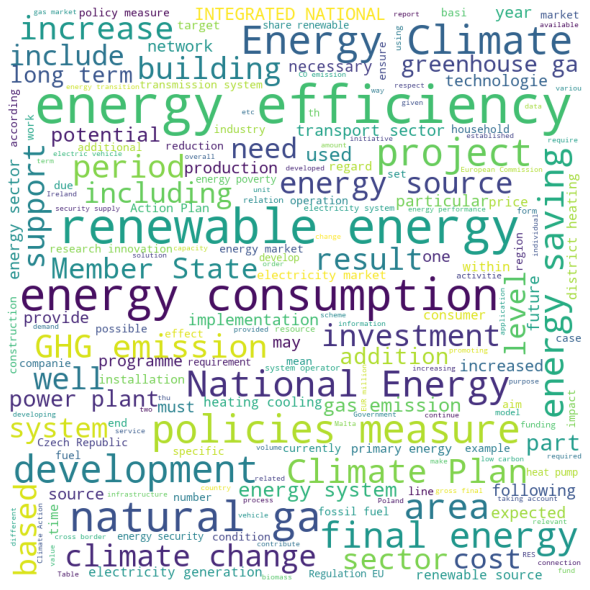

In [82]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(common_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

### 2b. Analysis on Plurals 

To analyze the relationship of the vectorized words and their pulral forms 

We load Google's pre-trained word2vec model to vectorize every word into a vector of size 300

In [7]:
model = KeyedVectors.load_word2vec_format(vector_location, binary=True) #loading a pre-trained Google embedding model

From the following statement we can see that the vector of singular form of the word is not equal to its plural form 

In [8]:
(model['nation']==model['Nations']).all()

False

We will load the file containing all the words and their plural forms 

In [9]:
plural = pd.read_csv(r'/home/bhawna/text_analytics/Gender_Dimension/output_new/most_common_plurals.csv')

There are some words in the file which have no plural forms, therefore only the words which have plural are taken into consideration

In [10]:
plural=plural[:11] 

We compute the similarity of the vectorized word and it's plural by taking pairs from all the words occurring in the male list and the female list 

- Male List = {man, male, he, father}
- Female List = {woman, female, she, mother}

In [11]:
plural['man_singular']=plural['Word'].apply(lambda x: model.similarity("man", x))
plural['man_plural']=plural['Word plural'].apply(lambda x: model.similarity("man", x))
plural['woman_singular']=plural['Word'].apply(lambda x: model.similarity("woman", x))
plural['woman_plural']=plural['Word plural'].apply(lambda x: model.similarity("woman", x))
plural['male_singular']=plural['Word'].apply(lambda x: model.similarity("male", x))
plural['male_plural']=plural['Word plural'].apply(lambda x: model.similarity("male", x))
plural['female_singular']=plural['Word'].apply(lambda x: model.similarity("female", x))
plural['female_plural']=plural['Word plural'].apply(lambda x: model.similarity("female", x))
plural['he_singular']=plural['Word'].apply(lambda x: model.similarity("he", x))
plural['he_plural']=plural['Word plural'].apply(lambda x: model.similarity("he", x))
plural['she_singular']=plural['Word'].apply(lambda x: model.similarity("she", x))
plural['she_plural']=plural['Word plural'].apply(lambda x: model.similarity("she", x))
plural['father_singular']=plural['Word'].apply(lambda x: model.similarity("father", x))
plural['father_plural']=plural['Word plural'].apply(lambda x: model.similarity("father", x))
plural['mother_singular']=plural['Word'].apply(lambda x: model.similarity("mother", x))
plural['mother_plural']=plural['Word plural'].apply(lambda x: model.similarity("mother", x))

In [12]:
plural

,Word,Word plural,man_singular,man_plural,woman_singular,woman_plural,male_singular,male_plural,female_singular,female_plural,he_singular,he_plural,she_singular,she_plural,father_singular,father_plural,mother_singular,mother_plural
0,measure,measures,0.048255,-0.020671,0.031771,-0.012342,0.119952,0.037194,0.069007,0.020425,0.127575,0.060263,0.077946,0.037171,0.017602,0.041376,0.016745,0.015107
1,transport,transports,0.017236,-0.011595,-0.002930,0.005754,-0.002699,0.057844,0.033222,0.072054,0.042974,0.007233,0.028554,0.020729,-0.018361,-0.047385,0.018252,-0.022506
2,sector,sectors,0.035529,-0.005908,0.037509,-0.003714,0.060956,0.047032,0.039395,0.028880,0.056744,0.001565,0.039776,0.004064,0.017494,-0.013418,-0.005521,-0.049529
3,emission,emissions,0.018873,0.022088,0.003689,-0.001675,-0.054332,-0.044296,-0.064881,-0.063424,0.009978,0.016047,-0.008070,-0.031413,0.009731,0.028203,0.014585,0.025505
4,market,markets,0.009960,-0.023517,0.035628,0.013899,0.068375,-0.022209,0.010918,-0.069894,0.049706,0.027990,0.031778,0.040863,-0.022881,-0.017851,-0.014812,-0.000711
5,increase,increases,0.015664,-0.012746,0.025839,0.022458,0.097062,0.065570,0.099465,0.053769,0.072060,0.041460,0.054007,0.067325,-0.021039,-0.061144,0.011106,0.003329
6,national,nationals,0.084865,0.182780,0.059047,0.203086,0.114352,0.165558,0.175138,0.192273,0.122506,0.110169,0.090269,0.130696,0.131019,0.106261,0.063348,0.141091
7,development,developments,0.005971,-0.032102,-0.003670,0.010199,0.002864,-0.052157,-0.000921,-0.034345,0.046820,0.056379,-0.009279,0.022128,0.048321,0.045374,0.031178,0.030497
8,energy,energies,0.023201,0.006714,-0.009654,-0.014238,-0.037055,0.045702,-0.020291,0.045154,0.129028,0.064431,0.086615,0.071580,0.016673,0.101353,0.004089,0.062429
9,gas,gases,0.094566,0.063358,0.092870,0.027061,-0.022441,-0.001126,-0.030444,-0.005248,0.121561,0.045860,0.112119,0.025612,0.056648,0.022701,0.067677,0.027071


Since the table is not clear we plot some charts to look into the values

#### Following piece of the code will generate distances of the energy words (both singular and form) with the male words

Text(0, 0.5, 'Distance')

<Figure size 576x360 with 0 Axes>

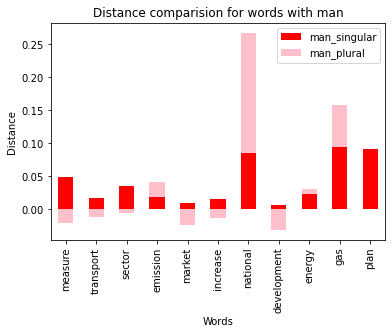

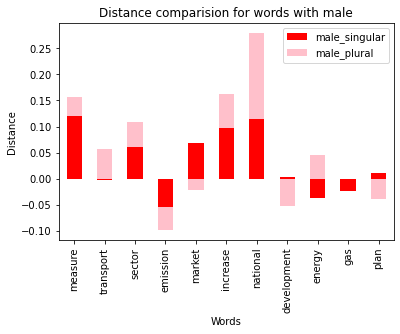

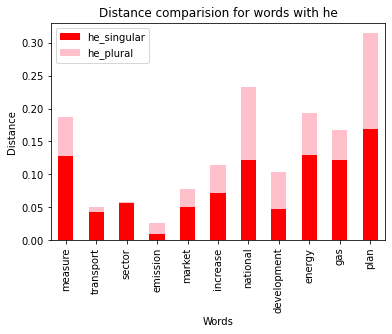

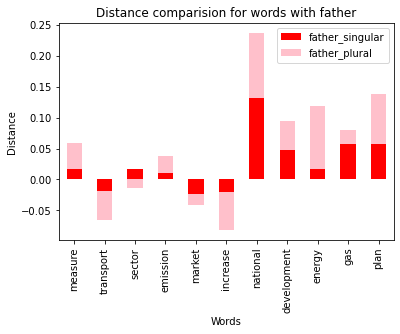

In [13]:
man_data = plural[['Word', 'man_singular', 'man_plural']].set_index('Word')
plt.figure(figsize=(8,5)) 
man_data.plot(kind='bar', stacked= True, color=['red', 'pink'])
plt.title('Distance comparision for words with man')
plt.xlabel('Words')
plt.ylabel('Distance')
male_data = plural[['Word', 'male_singular', 'male_plural']].set_index('Word')
male_data.plot(kind='bar', stacked= True, color=['red', 'pink'])
plt.title('Distance comparision for words with male')
plt.xlabel('Words')
plt.ylabel('Distance')
he_data = plural[['Word', 'he_singular', 'he_plural']].set_index('Word')
he_data.plot(kind='bar', stacked= True, color=['red', 'pink'])
plt.title('Distance comparision for words with he')
plt.xlabel('Words')
plt.ylabel('Distance')
father_data = plural[['Word', 'father_singular', 'father_plural']].set_index('Word')
father_data.plot(kind='bar', stacked= True, color=['red', 'pink'])
plt.title('Distance comparision for words with father')
plt.xlabel('Words')
plt.ylabel('Distance')

The graphs indicate that the stacked bars are not equal, indicating that the distance measure or the similarity metric of the word and its plurl form is different and not the same in case of the male words. 

Text(0, 0.5, 'Distance')

<Figure size 576x360 with 0 Axes>

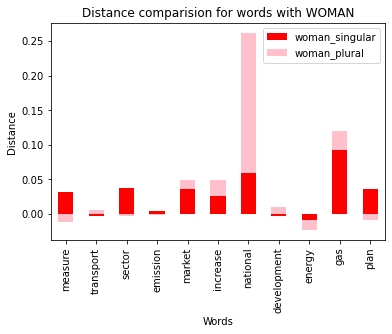

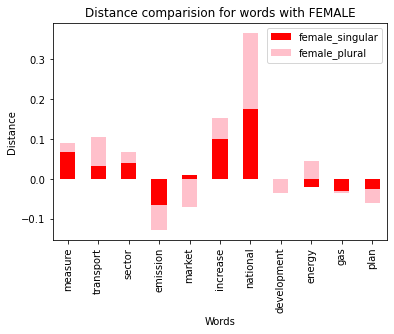

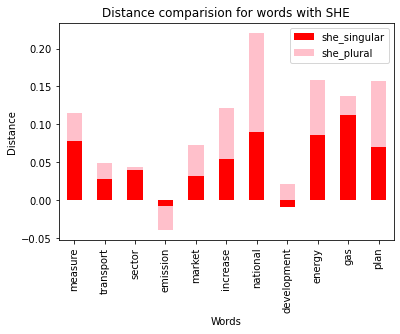

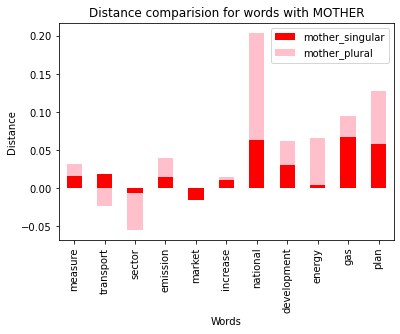

In [14]:
woman_data = plural[['Word', 'woman_singular', 'woman_plural']].set_index('Word')
plt.figure(figsize=(8,5)) 
woman_data.plot(kind='bar', stacked= True, color=['red', 'pink'])
plt.title('Distance comparision for words with WOMAN')
plt.xlabel('Words')
plt.ylabel('Distance')
female_data = plural[['Word', 'female_singular', 'female_plural']].set_index('Word')
female_data.plot(kind='bar', stacked= True, color=['red', 'pink'])
plt.title('Distance comparision for words with FEMALE')
plt.xlabel('Words')
plt.ylabel('Distance')
she_data = plural[['Word', 'she_singular', 'she_plural']].set_index('Word')
she_data.plot(kind='bar', stacked= True, color=['red', 'pink'])
plt.title('Distance comparision for words with SHE')
plt.xlabel('Words')
plt.ylabel('Distance')
mother_data = plural[['Word', 'mother_singular', 'mother_plural']].set_index('Word')
mother_data.plot(kind='bar', stacked= True, color=['red', 'pink'])
plt.title('Distance comparision for words with MOTHER')
plt.xlabel('Words')
plt.ylabel('Distance')

The graphs indicate that the stacked bars are not equal, indicating that the distance measure or the similarity metric of the word and its plurl form is different and not the same in case of the female words. 

#### Overall comparision of the distances : Histogram

<AxesSubplot:xlabel='man_singular', ylabel='Count'>

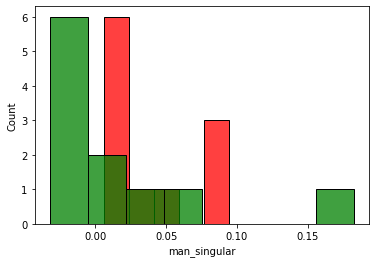

In [15]:
sns.histplot(plural['man_singular'], color='red' )
sns.histplot(plural['man_plural'], color='green')


<AxesSubplot:xlabel='woman_singular', ylabel='Count'>

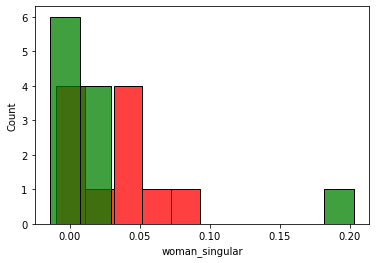

In [16]:
sns.histplot(plural['woman_singular'], color='red' )
sns.histplot(plural['woman_plural'], color='green')

The following code for generates the Word Embedding graph for all the words commonly occuring in the member states and the basic male and femaale words ['he', 'man', 'male', 'father'] and the counterpart

The code typically calculates PCA on the 300 vector size and then plot those components in 2D

### 2C. Plotting the word embeddings in general context

Looking into the relationship b/w {'Man', 'Woman', 'Engineer', 'Nurse'}

In [17]:
words = {'Man', 'Woman', 'Engineer', 'Nurse'}

In [18]:
dict_words_vector={}
for word in words:
    dict_words_vector[word] = model[word]
    
all_values=[]
for key,values in dict_words_vector.items():
    all_values.append(values)

In [19]:
new=pd.DataFrame(all_values)
new.index=words

In [20]:
new

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
Engineer,-0.149414,-0.108887,0.022583,-0.261719,-0.304688,0.168945,-0.086914,-0.080566,-0.231445,0.001930,...,-0.177734,-0.208008,-0.339844,0.318359,-0.073730,0.251953,-0.326172,-0.289062,0.024414,-0.049072
Woman,0.281250,0.061279,-0.149414,-0.153320,0.462891,-0.239258,-0.427734,0.160156,0.229492,0.062988,...,0.187500,-0.056152,-0.443359,-0.084961,-0.030396,0.094238,-0.154297,0.108887,-0.084473,0.007812
Nurse,-0.076660,-0.080566,0.181641,-0.016968,0.019165,0.204102,-0.138672,-0.063477,0.086914,-0.289062,...,0.208984,-0.204102,-0.289062,0.009277,-0.255859,0.250000,-0.041748,0.044434,0.096680,0.269531
Man,0.103516,0.089844,-0.047852,0.022461,0.213867,-0.042725,-0.241211,0.162109,0.363281,-0.113281,...,0.056885,0.079590,-0.233398,-0.013062,-0.064453,0.056885,-0.453125,-0.056396,-0.137695,-0.010315


In [21]:
pca = PCA(n_components=2)
result = pca.fit_transform(new)

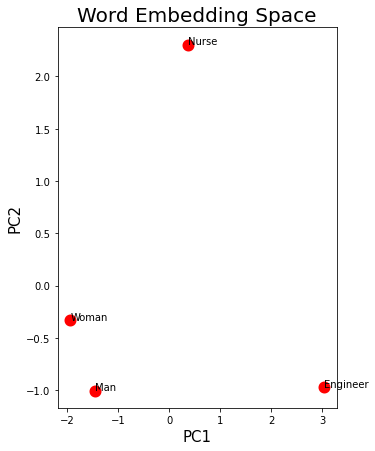

In [22]:
plt.figure(figsize=(5,7))
plt.scatter(result[:,0],result[:,1],linewidths=6,color='red')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
for i, word in enumerate(words):
    plt.annotate(word,xy=(result[i,0],result[i,1]))

As expected Man is closer to engineer and farther from nurse while Woman is closer to Nurse and farther from Engineer

Now looking into the word embeddings of the Leader and Follower w.r.t to the words explored just now

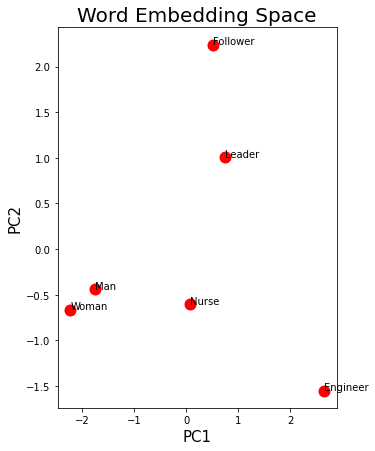

In [23]:
words = {'Man', 'Woman', 'Engineer', 'Nurse', 'Leader', 'Follower'}

dict_words_vector={}
for word in words:
    dict_words_vector[word] = model[word]
    
all_values=[]
for key,values in dict_words_vector.items():
    all_values.append(values)
    
new=pd.DataFrame(all_values)
new.index=words

pca = PCA(n_components=2)

result = pca.fit_transform(new)

plt.figure(figsize=(5,7))
plt.scatter(result[:,0],result[:,1],linewidths=6,color='red')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
for i, word in enumerate(words):
    plt.annotate(word,xy=(result[i,0],result[i,1]))

Man is closer to both Follower and Leader

### 2d. Plotting the word embeddings in Energy Domain 

In [89]:
energy=['climate',
 'national',
 'market',
 'measures',
 'emissions',
 'electricity',
 'increase',
 'sector',
 'transport',
 'energy',
 'gas',
 'consumption',
 'plan',
 'development']

In [90]:
male_words = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son', 'father', 'uncle', 'grandfather']
female_words = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter', 'mother', 'aunt', 'grandmother']

In [91]:
words = energy+male_words+female_words

In [92]:
dict_words_vector={}
for word in words:
    dict_words_vector[word] = model[word]
    
all_values=[]
for key,values in dict_words_vector.items():
    all_values.append(values)

In [93]:
new=pd.DataFrame(all_values)
new.index=words

In [94]:
new

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
climate,0.178711,0.326172,-0.118652,0.120605,-0.155273,-0.210938,0.004608,-0.038818,-0.006775,0.167969,...,-0.394531,0.154297,0.173828,0.201172,0.211914,0.135742,-0.003601,0.417969,0.314453,0.065430
national,-0.135742,0.175781,0.117188,0.078613,0.052490,-0.238281,0.092773,-0.083984,0.061523,-0.062500,...,0.034180,-0.039551,0.034424,-0.075195,0.006775,-0.110840,0.069336,-0.068359,0.032471,-0.009338
market,-0.156250,-0.087891,-0.229492,-0.231445,-0.007935,-0.203125,-0.023682,-0.092285,0.223633,0.056396,...,0.038330,0.080566,-0.065918,-0.087402,0.059082,0.231445,-0.050781,0.141602,0.047363,-0.013550
measures,-0.142578,0.363281,0.165039,0.044922,-0.082520,-0.058350,0.037109,0.066895,0.056152,-0.191406,...,-0.404297,-0.048828,0.259766,-0.086914,-0.081055,0.160156,0.064453,0.141602,0.045898,-0.107422
emissions,0.015137,-0.041748,0.503906,0.091309,-0.306641,-0.237305,0.088379,-0.029419,0.271484,0.429688,...,-0.141602,0.123535,0.324219,-0.100098,-0.177734,0.223633,0.114258,0.316406,0.223633,-0.100586
electricity,0.034180,0.019287,0.275391,-0.408203,0.102539,-0.039062,0.096191,-0.402344,0.181641,0.142578,...,-0.233398,-0.136719,-0.308594,0.073242,-0.108398,-0.003387,-0.292969,-0.014771,0.275391,0.044678
increase,-0.105957,-0.123047,-0.158203,0.205078,-0.127930,-0.105469,-0.105469,-0.298828,0.167969,0.250000,...,0.000441,0.096680,-0.118164,-0.085938,-0.271484,-0.089844,-0.245117,0.005371,-0.121582,-0.075684
sector,0.014954,-0.251953,-0.083984,-0.041992,-0.139648,-0.185547,-0.169922,-0.281250,0.062988,-0.208984,...,-0.167969,-0.153320,-0.212891,-0.055908,-0.047119,-0.212891,-0.156250,-0.106934,-0.062500,-0.073242
transport,0.011902,-0.016357,-0.010925,0.039551,-0.112793,-0.155273,-0.160156,-0.345703,0.132812,-0.061035,...,-0.330078,-0.166016,0.021362,0.080566,0.022217,-0.007050,-0.155273,-0.024780,0.055420,0.012817
energy,-0.103516,0.161133,0.117188,-0.253906,0.008911,0.008240,0.103027,-0.400391,0.094238,0.030640,...,-0.237305,-0.132812,-0.015198,-0.093262,-0.079102,-0.065430,0.186523,0.045898,0.153320,0.240234


In [95]:
pca = PCA(n_components=2)
result = pca.fit_transform(new)

In [96]:
result

array([[ 1.4571111 ,  0.2577436 ],
       [ 0.69216245, -0.4359561 ],
       [ 1.1578888 , -0.27793992],
       [ 1.1639862 , -0.05403039],
       [ 2.01826   ,  1.9481909 ],
       [ 1.3764689 ,  0.8841898 ],
       [ 1.1454871 , -0.2801083 ],
       [ 1.4126979 , -0.23106167],
       [ 1.330788  ,  0.15409547],
       [ 1.4787955 ,  0.60572666],
       [ 1.2039624 ,  0.59856576],
       [ 1.5758212 ,  0.4014488 ],
       [ 0.8128621 , -0.12813905],
       [ 0.9409077 , -0.13654839],
       [ 0.15800318, -1.6731975 ],
       [-0.43541196, -0.6658448 ],
       [-1.1282827 , -0.39047834],
       [-1.2570746 ,  0.8334397 ],
       [ 0.10299813, -0.35646245],
       [-0.13989513, -0.41608006],
       [ 0.06272711, -0.46238184],
       [-1.3891555 ,  0.624162  ],
       [-1.2618339 ,  0.67146087],
       [-1.3269317 ,  0.9317868 ],
       [-1.253615  ,  1.0662897 ],
       [ 0.22551747, -1.7663236 ],
       [-0.75147855, -1.1146303 ],
       [-1.1356782 , -0.78819937],
       [-1.2302985 ,

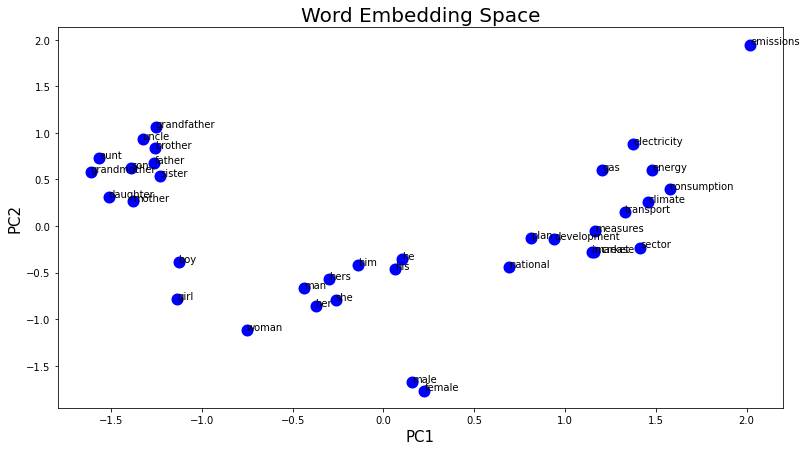

In [97]:
plt.figure(figsize=(13,7))
plt.scatter(result[:,0],result[:,1],linewidths=6,color='blue')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
for i, word in enumerate(words):
    plt.annotate(word,xy=(result[i,0],result[i,1]))

### 2e. Word Embedding plot for all the countries

dk_final_necp_main_en_0.csv
hu_final_necp_main_en_0.csv
lt_final_necp_main_en_0.csv
The vector for lithuania doesnt esixt
hr_final_necp_main_en_0.csv
es_final_necp_main_en_0.csv
The vector for inecp doesnt esixt
cs_final_necp_main_en_0.csv
pl_final_necp_main_en_0.csv
The vector for ecp doesnt esixt
el_final_necp_main_en_0.csv
fi_final_necp_main_en_0.csv
ie_final_necp_main_en_0.csv
be_final_necp_main_en_0.csv
The vector for flemish doesnt esixt
at_final_necp_main_en_0.csv
ee_final_necp_main_en_0.csv
The vector for estonia doesnt esixt
The vector for estonian doesnt esixt
de_final_necp_main_en_0.csv
The vector for programme doesnt esixt
nl_final_necp_main_en_0.csv
cy_final_necp_main_en_0.csv
se_final_necp_main_en_0.csv
lv_final_necp_main_en_0.csv
The vector for latvia doesnt esixt
sk_final_necp_main_en_0.csv
The vector for slovak doesnt esixt
si_final_necp_main_en_0.csv
The vector for slovenia doesnt esixt
The vector for nepn doesnt esixt
pt_final_necp_main_en_0.csv
The vector for necp d

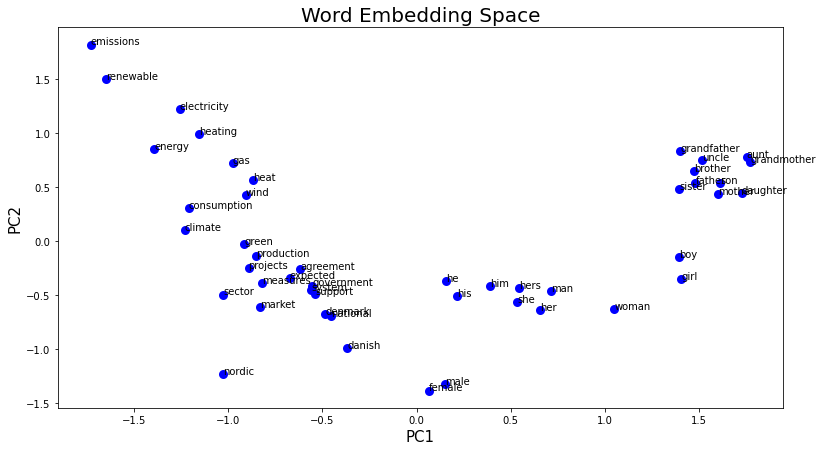

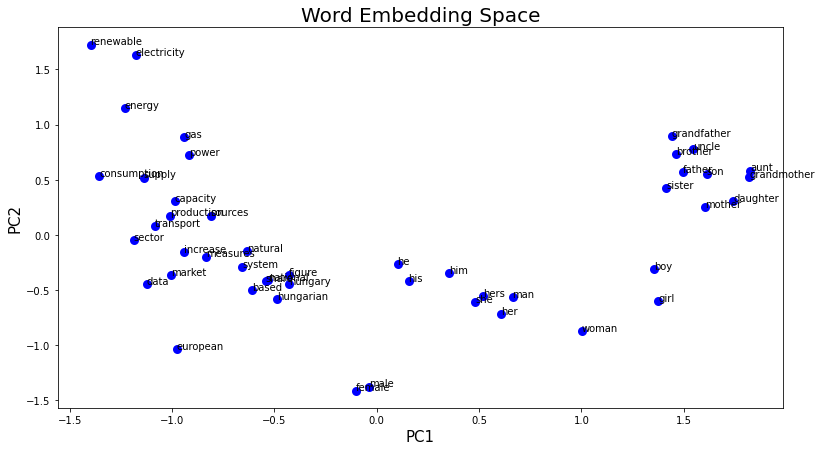

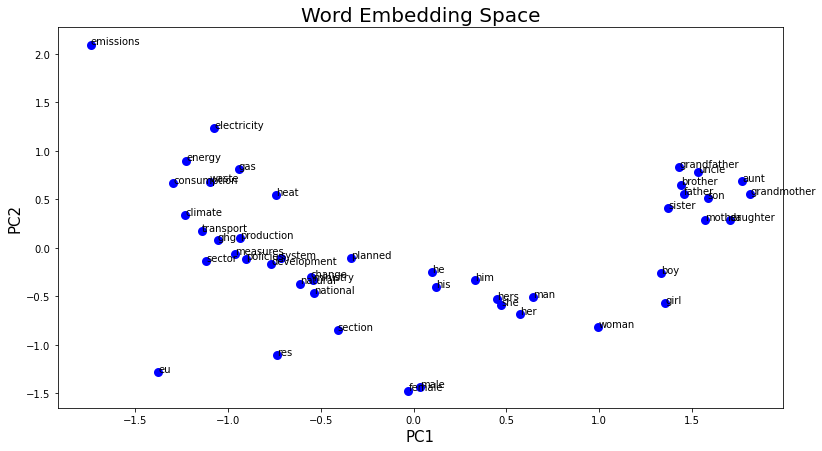

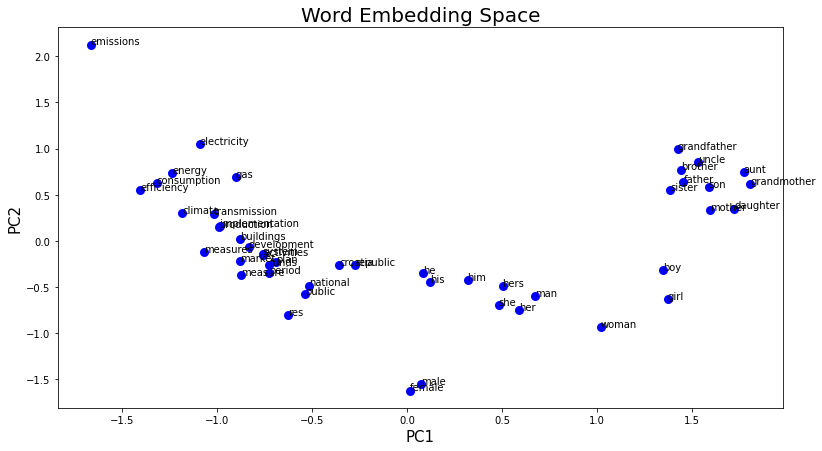

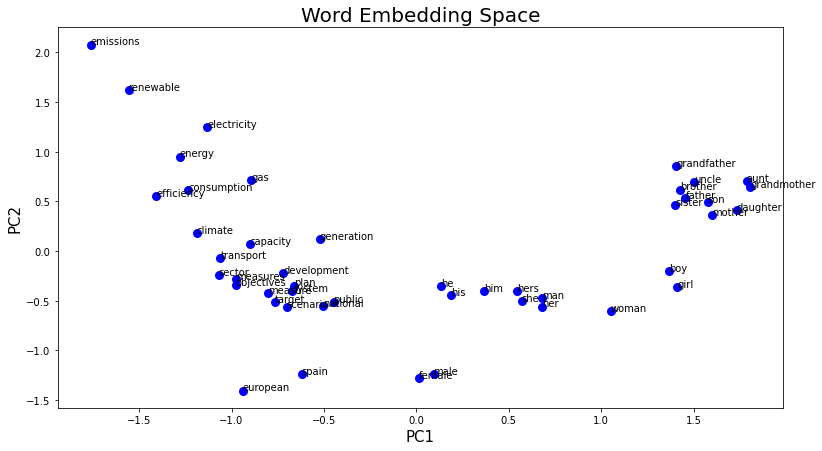

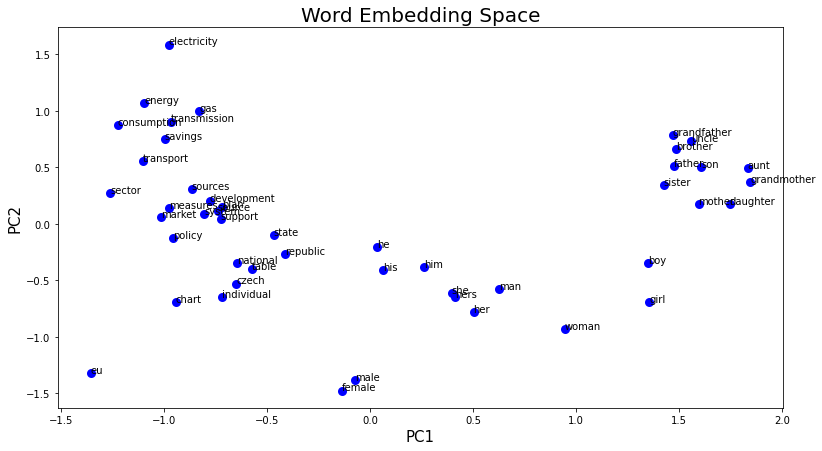

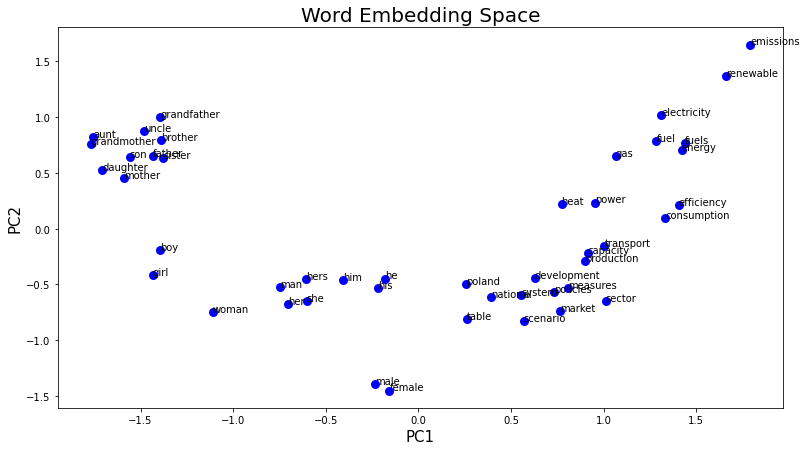

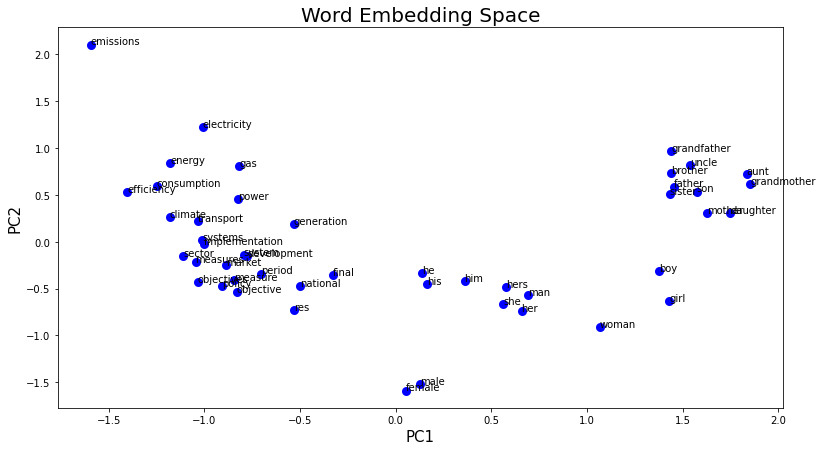

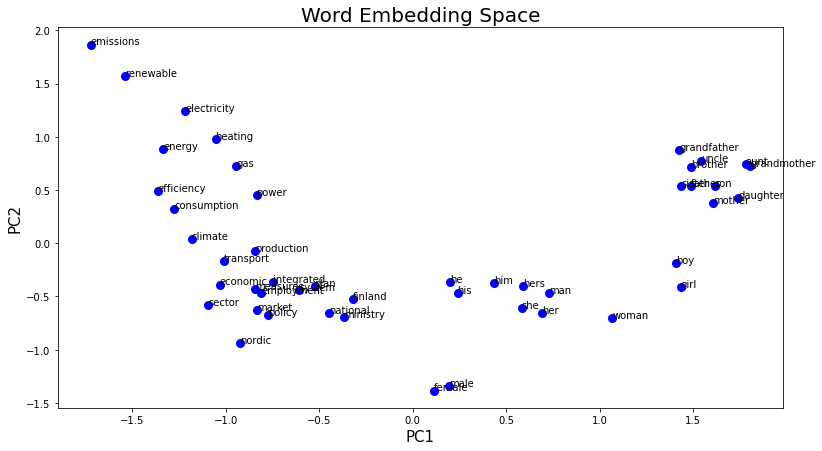

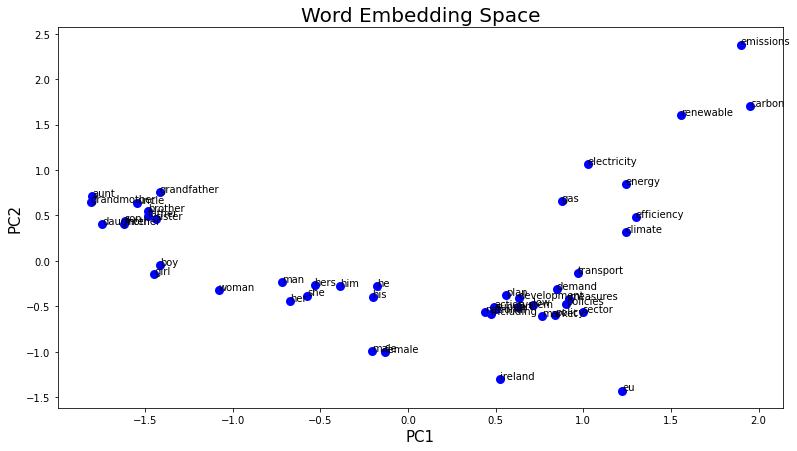

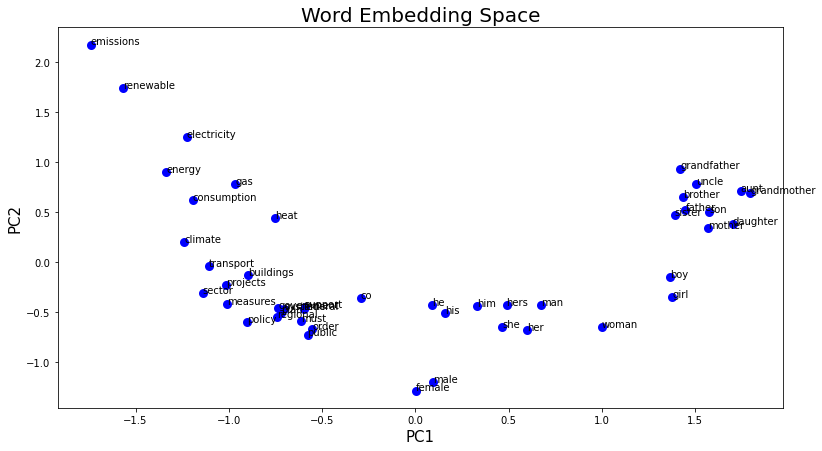

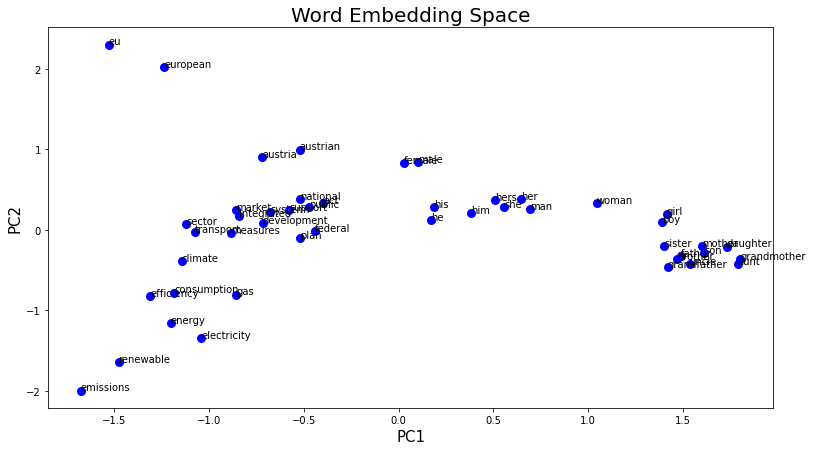

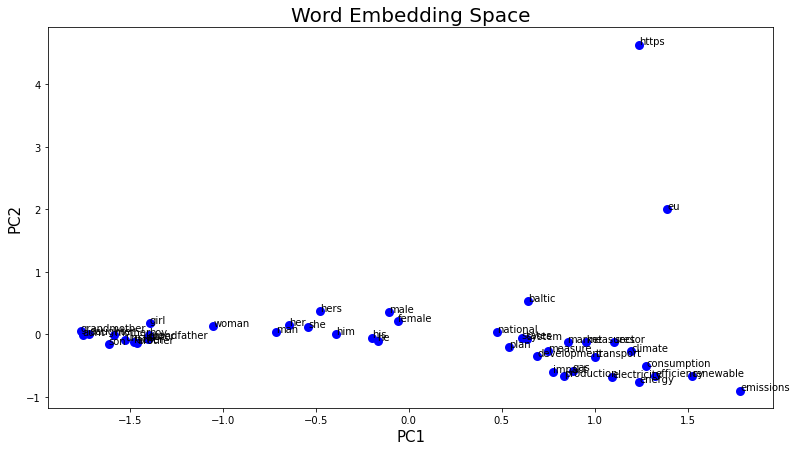

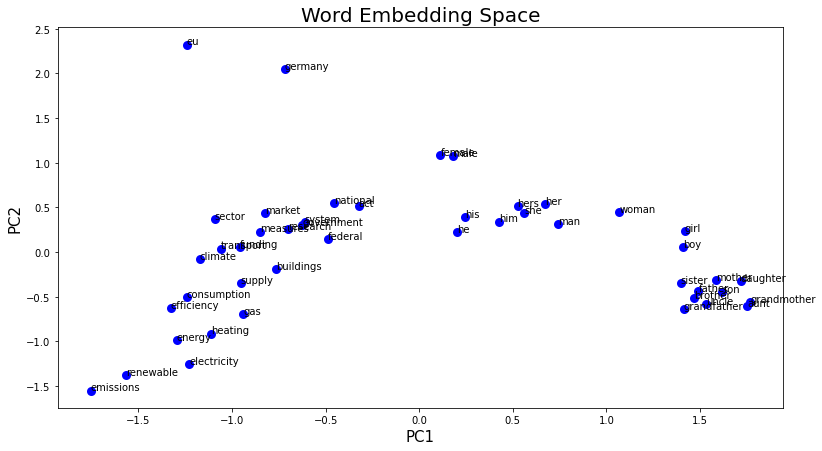

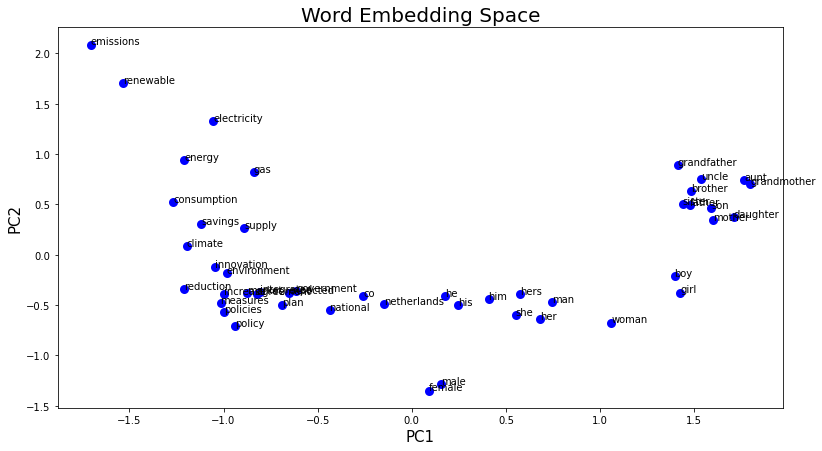

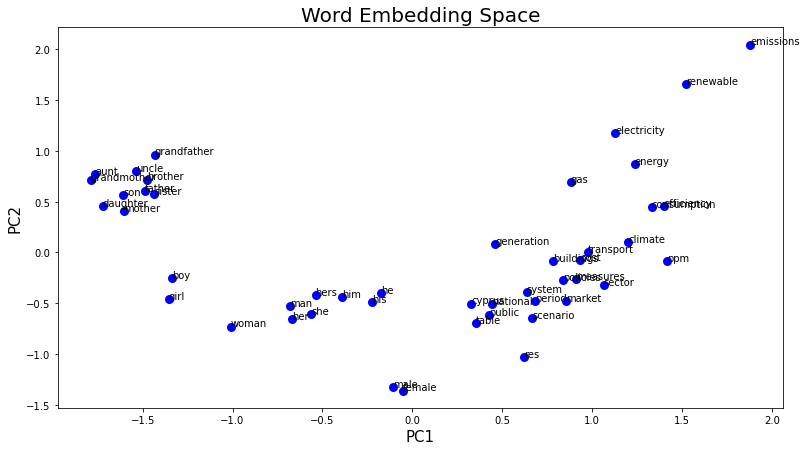

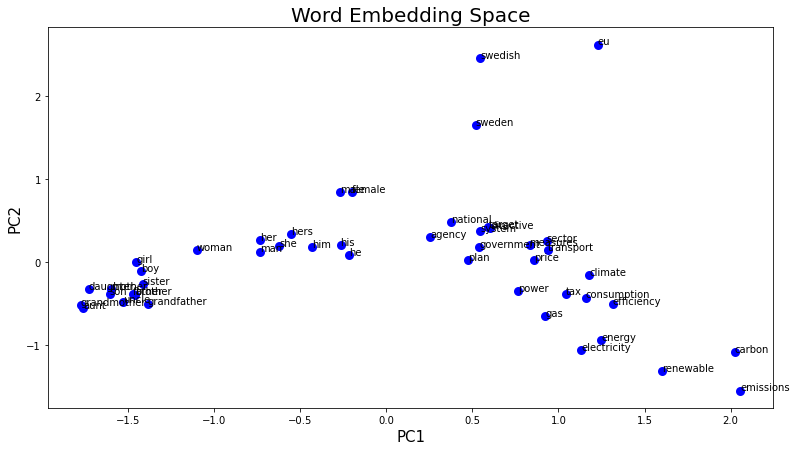

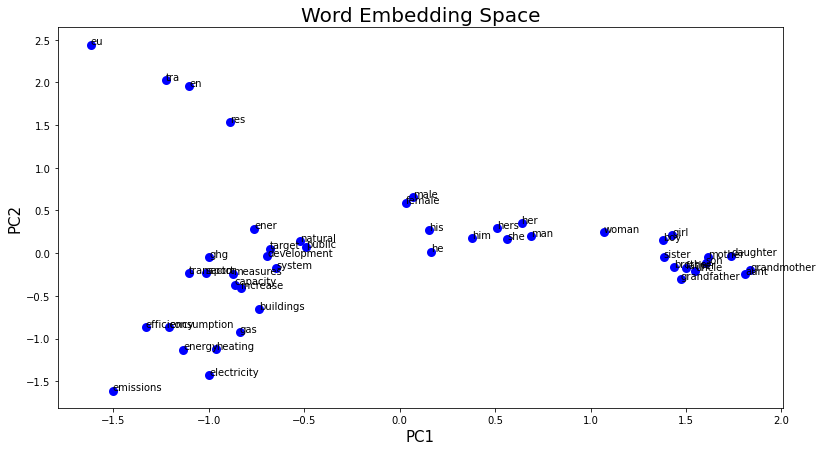

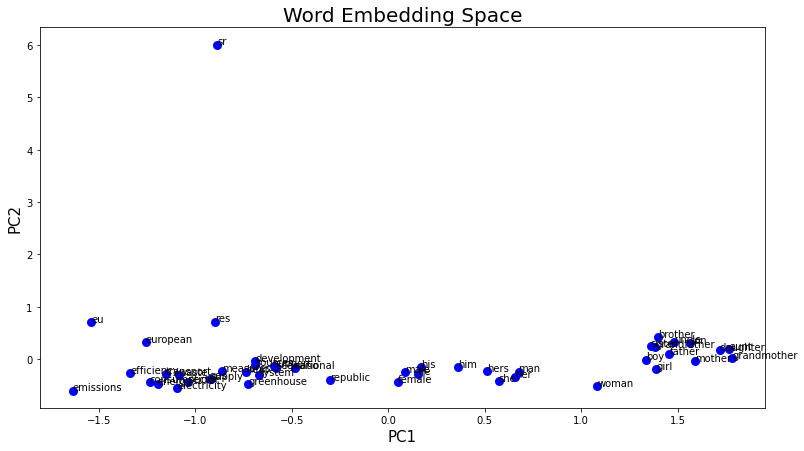

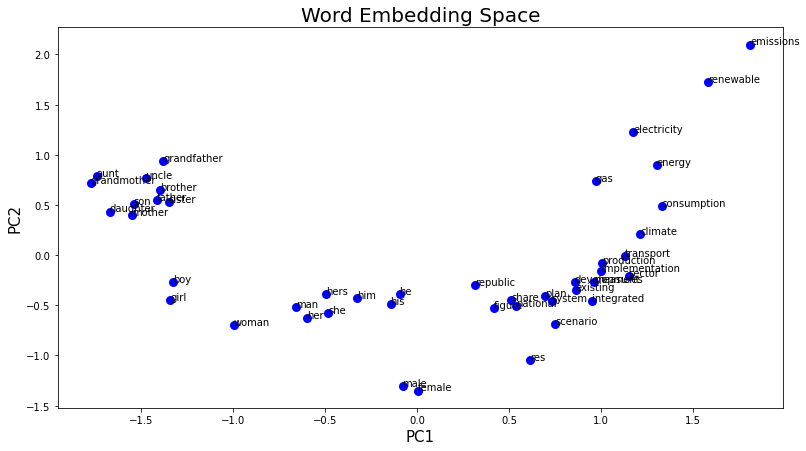

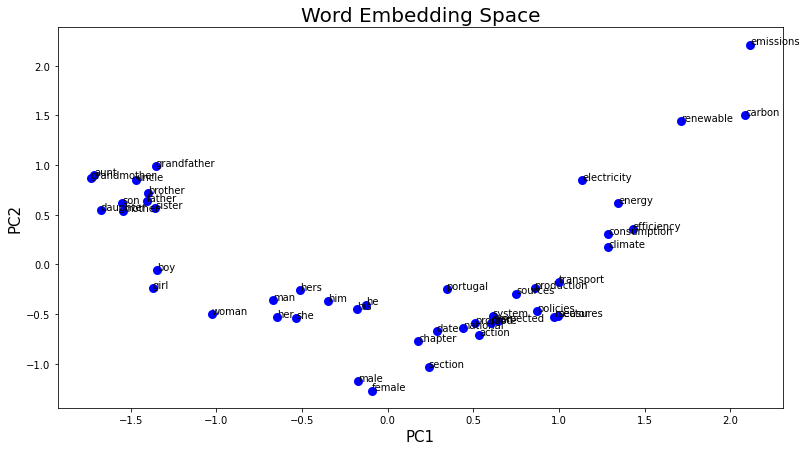

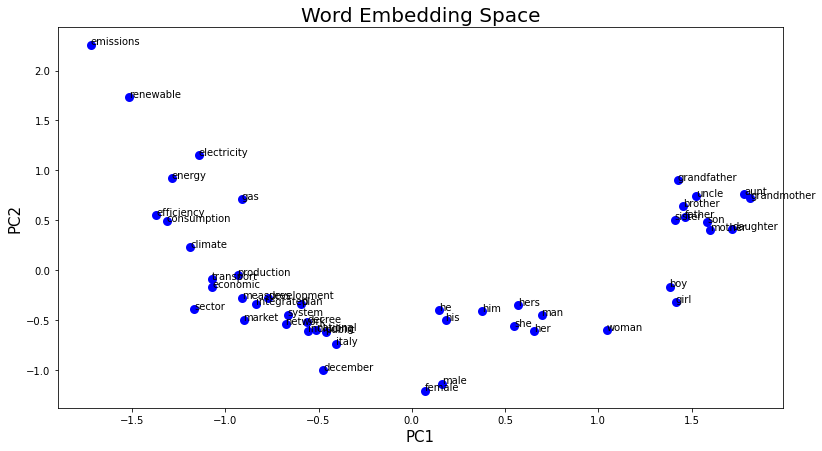

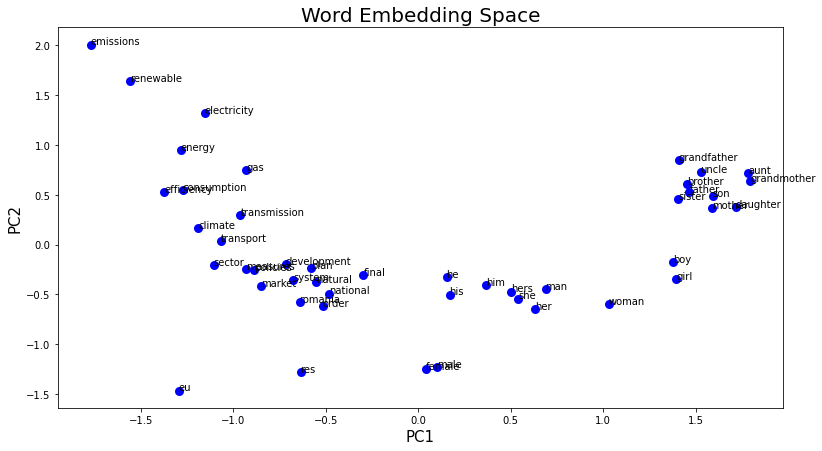

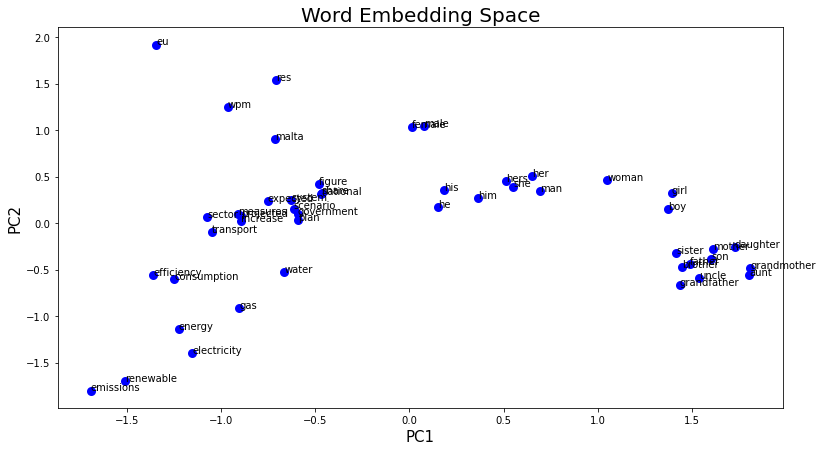

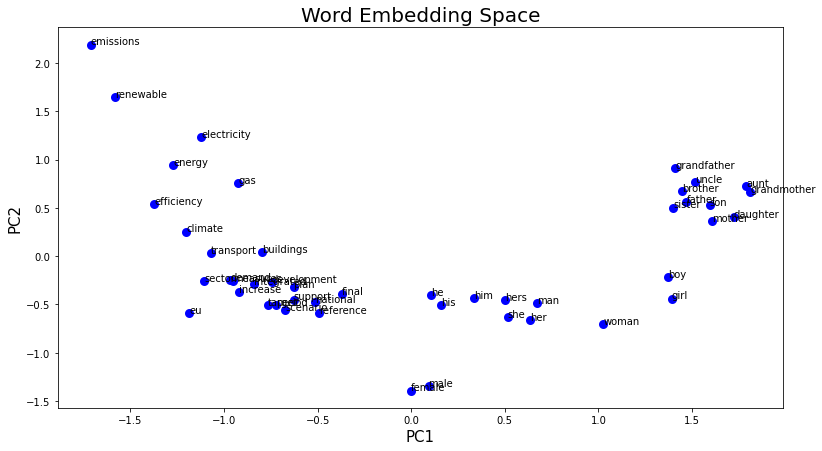

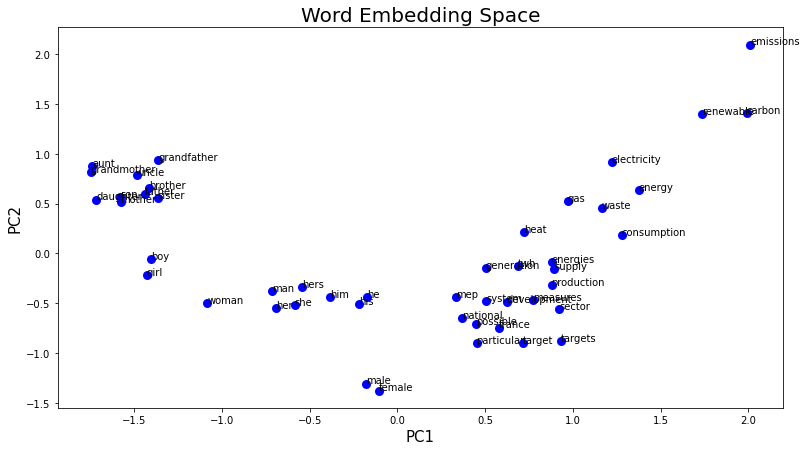

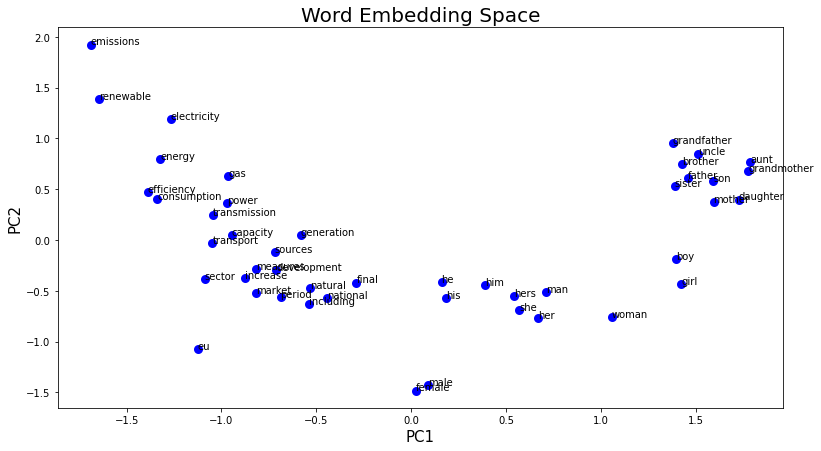

In [33]:
os.chdir(output_data_location)
all_necps_csv_filepath = []
for file in glob.glob("*main_en_0.csv"):
    all_necps_csv_filepath.append(file)

male_words = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son', 'father', 'uncle', 'grandfather']
female_words = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter', 'mother', 'aunt', 'grandmother']
for necp in all_necps_csv_filepath:
    print(necp)
    all_values=[]
    words_not_found = []
    dict_words_vector={}
    labels = []
    df1 = pd.read_csv(necp)
    df1 = df1.head(25)
    individual_word_set = df1['word'].to_list()
    words = individual_word_set+ male_words + female_words
    for word in words:
        try:
            dict_words_vector[word] = model[word]
            labels.append(word)
        except:
            words_not_found.append(word)
            print(f'The vector for {word} doesnt esixt')
            pass
        
    for key,values in dict_words_vector.items():
        all_values.append(values)
    
    words = [word for word in words if word not in words_not_found]
    new=pd.DataFrame(all_values)
    new.index=words
    pca = PCA(n_components=2)
    result = pca.fit_transform(new)
    
    plt.figure(figsize=(13,7))
    plt.scatter(result[:,0],result[:,1],linewidths=3,color='blue')
    plt.xlabel("PC1",size=15)
    plt.ylabel("PC2",size=15)
    plt.title("Word Embedding Space",size=20)
    for i, word in enumerate(words):
        plt.annotate(word,xy=(result[i,0],result[i,1]))

## Part 3. Bias Evaluation

#### Checking the bias with the an initial list :- 

In [34]:
male_words = ['he', 'man', 'male', 'father']
female_words = ['she', 'woman', 'female', 'mother']

In [35]:
energy=['measures',
 'transport',
 'sector',
 'emissions',
 'electricity',
 'market',
 'increase',
 'national',
 'development',
 'climate',
 'energy',
 'gas',
 'plan',
 'consumption']

In [36]:
google_news = api.load('word2vec-google-news-300')

In [37]:
model1 = WordEmbeddingModel(google_news, 'google_news')

In [38]:
target_sets = []
target_sets.append(male_words)
target_sets.append(female_words)

In [39]:
target_sets

[['he', 'man', 'male', 'father'], ['she', 'woman', 'female', 'mother']]

In [40]:
attribute_sets = []
#word = word_occuring_in_all_documents['Word'].to_list()
attribute_sets.append(energy)

In [41]:
target_sets_names = ['Male Terms', 'Female Terms']
attribute_sets_name = ['Energy']
# create the query
query = Query(target_sets, attribute_sets, target_sets_names,
              attribute_sets_name)

In [42]:
RND().run_query(query, model1) 

{'query_name': 'Male Terms and Female Terms wrt Energy',
 'result': -0.18204990455082484,
 'rnd': -0.18204990455082484,
 'distances_by_word': {'plan': -0.2694645,
  'national': -0.23181629,
  'development': -0.22860193,
  'market': -0.2007482,
  'energy': -0.19927883,
  'sector': -0.19634795,
  'measures': -0.19348407,
  'emissions': -0.16940546,
  'increase': -0.16109705,
  'gas': -0.15570903,
  'transport': -0.14803576,
  'consumption': -0.14657235,
  'climate': -0.12866068,
  'electricity': -0.11947656}}

Interpretation: The more negative the score is the more is the association with the Male Category. 

#### This clearly indicates that the model is biased towards the male 

#### Expanding the list to Chaloner's list 

In [43]:
expanded_male_words = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son', 'father', 'uncle', 'grandfather']
expanded_female_words = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter', 'mother', 'aunt', 'grandmother']

expanded_target_sets = []
expanded_target_sets.append(expanded_male_words)
expanded_target_sets.append(expanded_female_words)

target_sets_names = ['Expanded Male Terms', 'Expanded Female Terms']
attribute_sets_name = ['Energy']
# create the query
query = Query(expanded_target_sets, attribute_sets, target_sets_names,
              attribute_sets_name)

RND().run_query(query, model1) 

{'query_name': 'Expanded Male Terms and Expanded Female Terms wrt Energy',
 'result': -0.14185542719704763,
 'rnd': -0.14185542719704763,
 'distances_by_word': {'plan': -0.2170732,
  'national': -0.20355964,
  'energy': -0.17686343,
  'sector': -0.17655921,
  'development': -0.1745894,
  'market': -0.15568328,
  'measures': -0.14062619,
  'increase': -0.13483524,
  'transport': -0.12860942,
  'gas': -0.1146698,
  'electricity': -0.096247435,
  'climate': -0.0930686,
  'emissions': -0.08683252,
  'consumption': -0.08675861}}

#### With expanded list it clearly indicates that the model is biased towards the male 

#### Now trying with all the individual country files

In [44]:
os.chdir(output_data_location)
all_necps_csv_filepath = []
for file in glob.glob("*main_en_0.csv"):
    all_necps_csv_filepath.append(file)

In [45]:
expanded_male_words = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son', 'father', 'uncle', 'grandfather']
expanded_female_words = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter', 'mother', 'aunt', 'grandmother']
expanded_target_sets = []
target_sets_names = ['Expanded Male Terms', 'Expanded Female Terms']
expanded_target_sets.append(expanded_male_words)
expanded_target_sets.append(expanded_female_words)

for necp in all_necps_csv_filepath:
    attribute_sets = []
    df1 = pd.read_csv(necp)
    attribute_sets.append(df1['word'].to_list())
    query = Query(expanded_target_sets, attribute_sets, target_sets_names, attribute_sets_name)
    data = RND().run_query(query, model1)['distances_by_word']
    df2 = pd.DataFrame.from_dict(data, orient='index', columns=['rnd_score']).reset_index().rename(columns = {'index': 'word'})
    df3 = (df1.merge(df2, on='word', how='left'))
    df3.to_csv(necp + ' merged_scores'+ '.csv', index=False)

In [46]:
all_scoress_filepath = []
for file in glob.glob('*merged_scores.csv'):
    all_scoress_filepath.append(file)

In [47]:
scores_across_countries = {}
for file in all_scoress_filepath:
    df1= pd.read_csv(file)
    df1 = df1.copy()
    df1['weight*rnd_score'] = df1['weight']*df1['rnd_score']
    score = (df1['weight*rnd_score'].sum())/(df1.weight.sum())
    df1['final_score'] = (df1['weight*rnd_score'].sum())/(df1.weight.sum())
    scores_across_countries[os.path.splitext(file)[0].split()[0]] = score

In [48]:
scores = pd.DataFrame.from_dict(scores_across_countries, orient='index', columns=['final_score']).reset_index().rename(columns={'index':'file'}) 

In [49]:
scores.sort_values('final_score')

,file,final_score
21,pt_final_necp_main_en_0.csv,-0.150049
13,it_final_necp_main_en_0.csv,-0.147303
25,el_final_necp_main_en_0.csv,-0.143879
6,es_final_necp_main_en_0.csv,-0.143653
19,ro_final_necp_main_en_0.csv,-0.143153
4,fr_final_necp_main_en_0.csv,-0.143002
23,at_final_necp_main_en_0.csv,-0.142498
18,fi_final_necp_main_en_0.csv,-0.141270
0,hr_final_necp_main_en_0.csv,-0.140733
9,cs_final_necp_main_en_0.csv,-0.140713


In [50]:
scores.sort_values('final_score').to_csv('final_scores_necp.csv', index=False)

This indicates that Portugal is the most biased and Slovenia is the least biased 

Looking at the word embedding chart for the most biased country - Portugal 

The vector for necp doesnt esixt


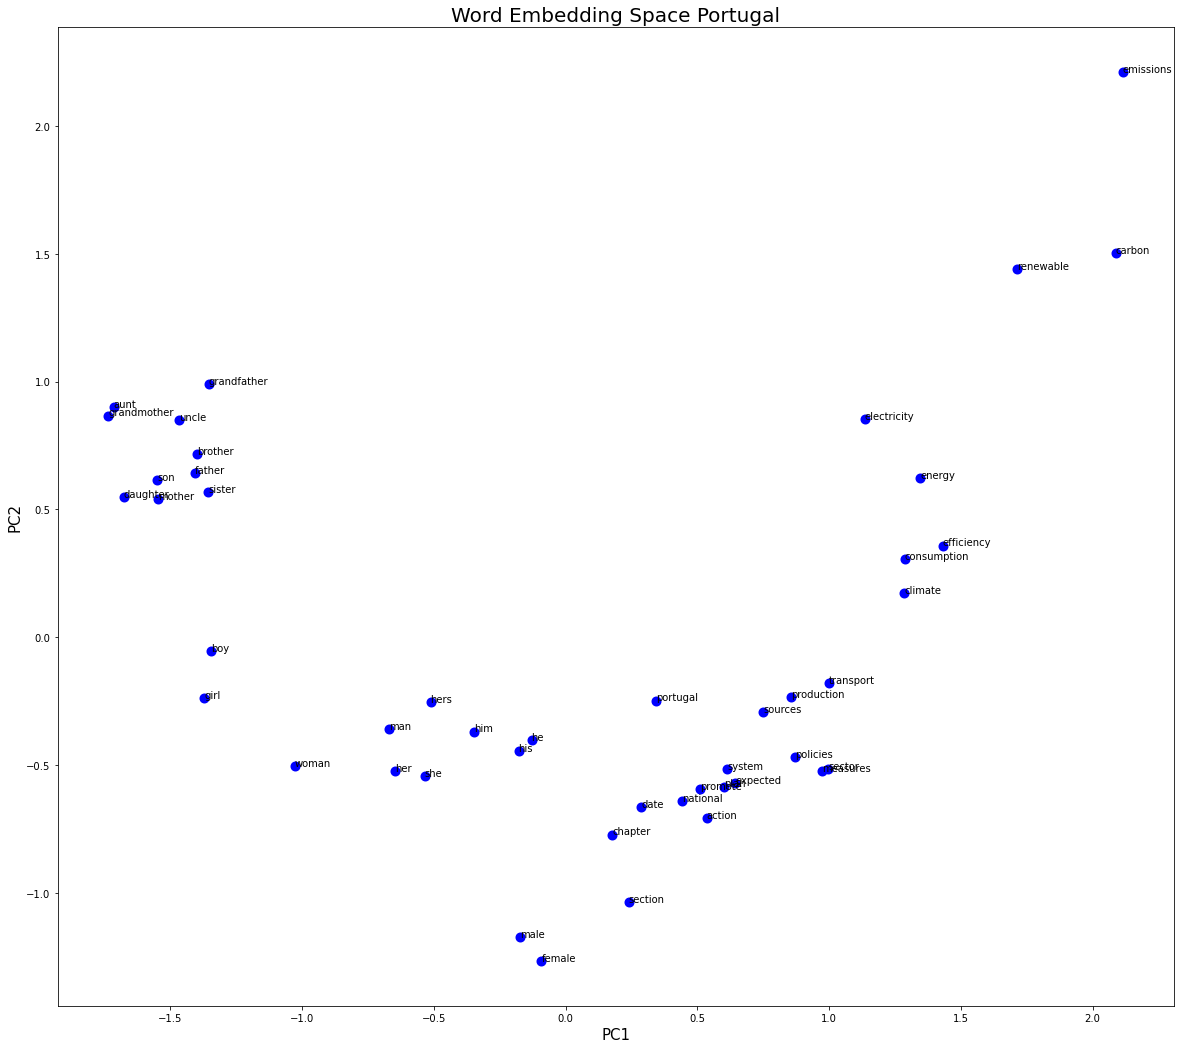

In [56]:
all_values=[]
words_not_found = []
dict_words_vector={}
labels = []
df1 = pd.read_csv('pt_final_necp_main_en_0.csv')
df1 = df1.head(25)
individual_word_set = df1['word'].to_list()
words = individual_word_set+ expanded_male_words + expanded_female_words
for word in words:
    try:
        dict_words_vector[word] = model[word]
        labels.append(word)
    except:
        words_not_found.append(word)
        print(f'The vector for {word} doesnt esixt')
        pass
        
for key,values in dict_words_vector.items():
    all_values.append(values)
    
words = [word for word in words if word not in words_not_found]
new=pd.DataFrame(all_values)
new.index=words
pca = PCA(n_components=2)
result = pca.fit_transform(new)
    
plt.figure(figsize=(20,18))
plt.scatter(result[:,0],result[:,1],linewidths=4,color='blue')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space Portugal",size=20)
for i, word in enumerate(words):
    plt.annotate(word,xy=(result[i,0],result[i,1]))

Looking at the word embedding chart for the most biased country - Slovenia

The vector for slovenia doesnt esixt
The vector for nepn doesnt esixt


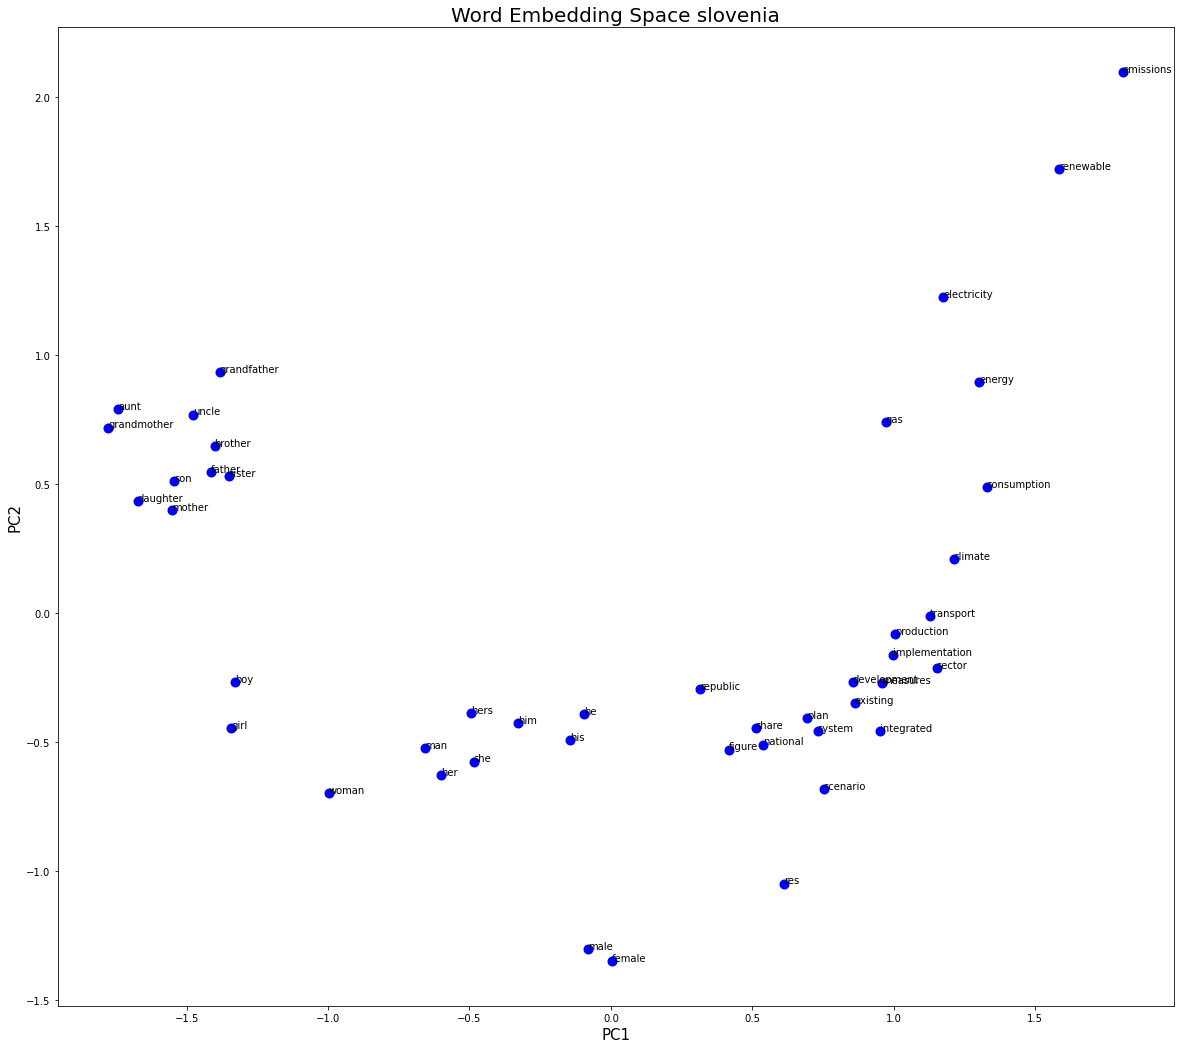

In [55]:
all_values=[]
words_not_found = []
dict_words_vector={}
labels = []
df1 = pd.read_csv('si_final_necp_main_en_0.csv')
df1 = df1.head(25)
individual_word_set = df1['word'].to_list()
words = individual_word_set+ expanded_male_words + expanded_female_words
for word in words:
    try:
        dict_words_vector[word] = model[word]
        labels.append(word)
    except:
        words_not_found.append(word)
        print(f'The vector for {word} doesnt esixt')
        pass
        
for key,values in dict_words_vector.items():
    all_values.append(values)
    
words = [word for word in words if word not in words_not_found]
new=pd.DataFrame(all_values)
new.index=words
pca = PCA(n_components=2)
result = pca.fit_transform(new)

plt.figure(figsize=(20,18))
plt.scatter(result[:,0],result[:,1],linewidths=4,color='blue')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space slovenia",size=20)
for i, word in enumerate(words):
    plt.annotate(word,xy=(result[i,0],result[i,1]))

#### WEAT  Query 

The idea is that the more positive the metric value, the more target T 1 will be
related to attribute A 1 and target T 2 to attribute A 2 . On the other hand, the more
negative the value, the more target T 1 will be related to attribute A 2 and target T 2
to attribute A 1 . The score that represents the absence of social bias is zero.

#### Arts vs Energy  

In [98]:
energy = word_occuring_in_all_documents['Word'].to_list()
arts = ['poetry','dance','literature', 'singing', 'painting', 'cooking']
expanded_male_words = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son', 'father', 'uncle', 'grandfather']
expanded_female_words = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter', 'mother', 'aunt', 'grandmother']

expanded_target_sets = []
expanded_target_sets.append(expanded_male_words)
expanded_target_sets.append(expanded_female_words)

target_sets_names = ['Expanded Male Terms', 'Expanded Female Terms']
attribute_sets = [arts, energy]
attribute_sets_name = ['Arts','Energy']
# create the query
query = Query(expanded_target_sets, attribute_sets, target_sets_names,
              attribute_sets_name)

WEAT().run_query(query, model1, calculate_p_value=True, p_value_iterations=5000) 

{'query_name': 'Expanded Male Terms and Expanded Female Terms wrt Arts and Energy',
 'result': -0.733634944043366,
 'weat': -0.733634944043366,
 'effect_size': -1.5027829370857655,
 'p_value': 0.9996000799840032}

#### Arts Vs Science

In [99]:
arts = ['poetry','dance','literature', 'singing', 'painting', 'cooking']
science = ['math', 'physics', 'chemistry', 'science', 'space', 'engineering']
expanded_male_words = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son', 'father', 'uncle', 'grandfather']
expanded_female_words = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter', 'mother', 'aunt', 'grandmother']

expanded_target_sets = []
expanded_target_sets.append(expanded_male_words)
expanded_target_sets.append(expanded_female_words)

target_sets_names = ['Expanded Male Terms', 'Expanded Female Terms']
attribute_sets = [arts, science]
attribute_sets_name = ['Arts','Science']
# create the query
query = Query(expanded_target_sets, attribute_sets, target_sets_names,
              attribute_sets_name)

WEAT().run_query(query, model1, calculate_p_value=True, p_value_iterations=5000)

{'query_name': 'Expanded Male Terms and Expanded Female Terms wrt Arts and Science',
 'result': -0.6181904222272958,
 'weat': -0.6181904222272958,
 'effect_size': -1.2461499485226326,
 'p_value': 0.9994001199760048}

#### Energy vs Science

In [100]:
energy = word_occuring_in_all_documents['Word'].to_list()
science = ['math', 'physics', 'chemistry', 'science', 'space', 'engineering']
expanded_male_words = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son', 'father', 'uncle', 'grandfather']
expanded_female_words = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter', 'mother', 'aunt', 'grandmother']

expanded_target_sets = []
expanded_target_sets.append(expanded_male_words)
expanded_target_sets.append(expanded_female_words)

target_sets_names = ['Expanded Male Terms', 'Expanded Female Terms']
attribute_sets = [energy, science]
attribute_sets_name = ['Energy','Science']
# create the query
query = Query(expanded_target_sets, attribute_sets, target_sets_names,
              attribute_sets_name)

WEAT().run_query(query, model1, calculate_p_value=True, p_value_iterations=5000)

{'query_name': 'Expanded Male Terms and Expanded Female Terms wrt Energy and Science',
 'result': 0.1154445218160704,
 'weat': 0.1154445218160704,
 'effect_size': 0.48202549541226036,
 'p_value': 0.1295740851829634}

#### Portugal vs Slovenia

In [102]:
os.chdir(output_data_location)
df_portugal = pd.read_csv('pt_final_necp_main_en_0.csv')
df_slovenia = pd.read_csv('si_final_necp_main_en_0.csv')


In [103]:
portugal_words = df_portugal['word'].to_list()
slovenia_words = df_slovenia['word'].to_list()
expanded_male_words = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son', 'father', 'uncle', 'grandfather']
expanded_female_words = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter', 'mother', 'aunt', 'grandmother']

expanded_target_sets = []
expanded_target_sets.append(expanded_male_words)
expanded_target_sets.append(expanded_female_words)

target_sets_names = ['Expanded Male Terms', 'Expanded Female Terms']
attribute_sets = [portugal_words, slovenia_words]
attribute_sets_name = ['Portugal','Slovenia']
# create the query
query = Query(expanded_target_sets, attribute_sets, target_sets_names,
              attribute_sets_name)

WEAT().run_query(query, model1, calculate_p_value=True, p_value_iterations=5000)

{'query_name': 'Expanded Male Terms and Expanded Female Terms wrt Portugal and Slovenia',
 'result': 0.06878002493780955,
 'weat': 0.06878002493780955,
 'effect_size': 0.8493012569540808,
 'p_value': 0.023195360927814438}

#### Part 4: Reference

#### WEAT Test Sample Query

In [104]:
target_sets = [['she', 'woman', 'girl'], ['he', 'man', 'boy']]
target_sets_names = ['Female Terms', 'Male Terms']
attribute_sets = [['poetry','dance','literature'], ['math', 'physics', 'chemistry']]
attribute_sets_names = ['Arts', 'Science']
# create the query
query = Query(target_sets, attribute_sets, target_sets_names,
              attribute_sets_names)

In [105]:
WEAT().run_query(query, model1, calculate_p_value=True, p_value_iterations=5000) 

{'query_name': 'Female Terms and Male Terms wrt Arts and Science',
 'result': 0.2539585799289246,
 'weat': 0.2539585799289246,
 'effect_size': 1.852439227993748,
 'p_value': 0.011095700416088766}

#### RND Test Sample Query

In [106]:
target_sets = [['she', 'woman', 'girl'], ['he', 'man', 'boy']]
target_sets_names = ['Female Terms', 'Male Terms']
attribute_sets = [['poetry','dance','literature']]
attribute_sets_names = ['Arts']
# create the query
query = Query(target_sets, attribute_sets, target_sets_names,
              attribute_sets_names)

In [107]:
RND().run_query(query, model1) 

{'query_name': 'Female Terms and Male Terms wrt Arts',
 'result': 0.004916667938232422,
 'rnd': 0.004916667938232422,
 'distances_by_word': {'dance': -0.045021057,
  'literature': 0.020332098,
  'poetry': 0.039438963}}